In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertTokenizer, TFBertModel
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Loading and Sampling the desired layer
tweets = pd.read_csv('../Data/tweets.csv', encoding='cp1252', header=None)
tweets.columns = ['target','id','date','flag','username','text'] #Change column names to things that make sense
tweets = tweets.drop(columns=['id','date','flag','username']) #Remove unneeded columns from memory
tweets = tweets.replace({'target':{0:0,4:1}}) #Dataset has only 0=negative sent, 4=positive sent, remappping to 0,1 respectivly
# print(tweets.shape)
tweets = tweets.groupby('target').sample(10000,random_state=None)
# print(tweets.shape)

# Tokenizing the data
# print(tweets.head())
features = tokenizer(tweets['text'].values.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='tf')
# tweets['text'] = tweets['text'].apply(lambda x: tokenizer(x.lower(), padding=True, truncation=True, max_length=128, return_tensors='tf'))
features = bert_model(**features).last_hidden_state[:,0,:]
# print("ONE FEATURE ASPECT")
# # print(features[14:15, :])
tweets['text'] = features.numpy().tolist()

#split data into train and test sets
X = np.array([x for x in tweets['text']])   # X = tweets.drop('target', axis=1)
Y = np.array([x for x in tweets['target']])  # Y = tweets['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=265)

#reduce dimensionality
#try to increase feature size later
# pca = PCA(n_components=3)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)

X_train = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test))/(np.max(X_test) - np.min(X_test))

print(type(X_train))

print(y_train.shape)
print(X_train.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

: 

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, Input, Concatenate
from tensorflow.keras.layers import Subtract
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
top_words = 100
NUM_CLASSES =  1

inputs = Input(shape=(X_train.shape[1],))
x = TokenAndPositionEmbedding(X_train.shape[1], top_words, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 768)]             0         
                                                                 
 token_and_position_embeddin  (None, 768, 32)          27776     
 g_12 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_12 (Trans  (None, 768, 32)          10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_642 (Dropout)       (None, 32)                0  

In [ ]:
# optimizer = Adam(learning_rate=1e-5)
model_xformer.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

history = model_xformer.fit(
    X_train, y_train, batch_size=64, epochs=30, 
    validation_data=(X_test, y_test)
)

Epoch 1/30
3/3 [==============================] - 5s 1s/step - loss: 0.6954 - accuracy: 0.4938 - val_loss: 0.7101 - val_accuracy: 0.3750
Epoch 2/30
3/3 [==============================] - 3s 964ms/step - loss: 0.6914 - accuracy: 0.5312 - val_loss: 0.7072 - val_accuracy: 0.3750
Epoch 3/30
3/3 [==============================] - 3s 952ms/step - loss: 0.6945 - accuracy: 0.5188 - val_loss: 0.7130 - val_accuracy: 0.3750
Epoch 4/30
3/3 [==============================] - 3s 960ms/step - loss: 0.6831 - accuracy: 0.5562 - val_loss: 0.7128 - val_accuracy: 0.3750
Epoch 5/30
3/3 [==============================] - 3s 957ms/step - loss: 0.6876 - accuracy: 0.5813 - val_loss: 0.7199 - val_accuracy: 0.3750
Epoch 6/30
3/3 [==============================] - 3s 941ms/step - loss: 0.6870 - accuracy: 0.5375 - val_loss: 0.7548 - val_accuracy: 0.3750
Epoch 7/30
3/3 [==============================] - 3s 985ms/step - loss: 0.7171 - accuracy: 0.5188 - val_loss: 0.7525 - val_accuracy: 0.3750
Epoch 8/30


KeyboardInterrupt: 

2/2 [==============================] - 0s 72ms/step


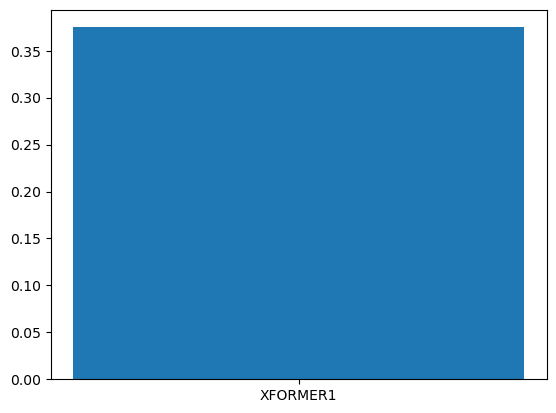

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt

# yhat_cnn = model_xformer.predict(X_test)
yhat_xformer = model_xformer.predict(X_test)

acc = [mt.accuracy_score(y_test,np.round(yhat_xformer))
      ]

plt.bar([1],acc)
plt.xticks([1],['XFORMER1'])
plt.show()

In [ ]:
#model.get_layer(*name u get from model.summary*)